In [5]:
# imports
import os
import pandas as pd
import re
import numpy as np

In [49]:
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

In [26]:
df = pd.read_excel('rxoconnect_19-01-2023.xlsx')

In [22]:
from db import DB
db = DB()
conn, cur = db.conn, db.cur

Connecting to the PostgreSQL database...


In [32]:
cur.execute('''SELECT column_name
FROM information_schema.columns 
WHERE table_schema = 'public' AND table_name = 'apartments_for_sale';''')
clmns = cur.fetchall()
columns = [col[0] for col in clmns]

cur.execute("SELECT * FROM apartments_for_sale;")
df = pd.DataFrame(cur.fetchall(), columns=columns)

In [47]:
# df[['price', 'duration']] = df.price.str.split(expand=True)
df['price'] = df.loc[:, 'price'].fillna(np.nan).astype(float)

In [66]:
price = df['price'].to_frame()

In [67]:
price['SMA30'] = price['price'].rolling(150).mean()

In [68]:
price.dropna(inplace=True)

<AxesSubplot:>

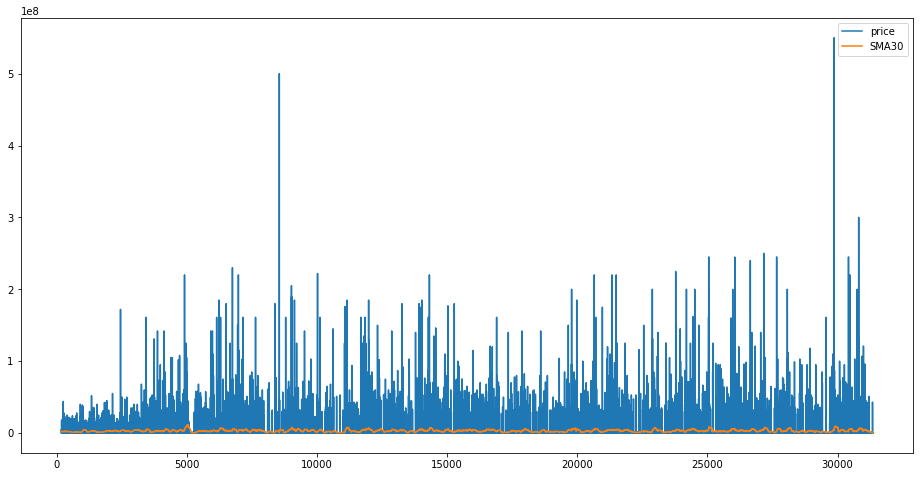

In [70]:
price[['price', 'SMA30']].plot(label='RELIANCE',
                                  figsize=(16, 8))

In [74]:
price.describe

<bound method NDFrame.describe of            price         SMA30
161    4300000.0  2.082569e+06
162       7000.0  2.081896e+06
163      14000.0  2.081336e+06
164      18000.0  2.080556e+06
165      90000.0  2.079723e+06
...          ...           ...
31349   124000.0  1.038057e+06
31350    89000.0  1.038070e+06
31351   225000.0  1.038570e+06
31352   180000.0  6.997700e+05
31353    93000.0  6.994433e+05

[31193 rows x 2 columns]>

In [27]:
df['price'] = df['price'].replace({"bid only": "1", "quick bid": "2", ",":""}, regex=True).astype(float)
df.sort_values(by='price', ascending=False, inplace=True)
df['price'] = df['price'].replace({1: "bid only", "quick bid": 2})

In [30]:
df.tail()

,load_id,load_type,pick_up_city,pick_up_state,pick_up_date,deliver_city,deliver_state,deliver_date,price,distance,stops,equipment,hot deal
2762,12748846,NaN,Lewisville,TX,"Jan 25, 03:15 PM CDT",Fort Worth,TX,"Jan 25, 10:00 PM CDT",bid only,40.3 mi,NaN,live Van - 53 Feet19344 LB Consumer Goods,no
552,12748964,high value load,Windsor,ON,"Jan 20, 10:00 AM - 02:00 PM EST",Normal,IL,"Jan 23, 08:30 AM CDT",bid only,395 mi,NaN,live Van - 53 Feet33623 LB Automotive Fre...,no
2751,12746144,NaN,Springfield,MO,"Jan 25, 02:00 PM CDT",Albuquerque,NM,"Jan 27, 08:00 AM MDT",bid only,829.3 mi,NaN,live Van or Reefer - 5314285 LB Food Stuffs,no
2746,12754371,NaN,Kent,OH,"Jan 25, 04:00 PM EDT",Quakertown,PA,"Jan 26, 06:00 AM EST",bid only,380.4 mi,NaN,live Reefer - 5342039 LB Food Stuffs,no
2570,12749220,NaN,Bartlett,IL,"Jan 25, 09:00 AM - 11:00 AM CDT",El Paso,TX,"Jan 27, 08:00 AM - 10:00 AM MDT",bid only,1483.6 mi,1 STOP,live Van - 53 Feet30000 LB Automotive Fre...,no


In [21]:
# pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', None)

### Define functions to get files and manipulate dataframes

In [6]:
# get all files full paths in data folder
def get_files(data_dir='data'):
    is_dir = os.path.isdir(data_dir)
    if not is_dir:
        print(f'\"{os.getcwd()}/{data_dir}\" directory does not exist, please specify correct data directory.')
        exit()
    files = []
    for root, dirs, filenames in os.walk(data_dir):
        for name in filenames:
            f = os.path.join(root, name)
            if f.endswith('data.csv'):
                files.append(f)
            else:
                continue

    return files


# rename columns: make lowercase, replace 'space' with '_'
def rename_cols(df):
    cols = []
    for col in df.columns.to_list():
        col = col.strip().replace(' ', '_').lower()
        cols.append(col)
    df.columns = cols


# populate list by list of files grouped by property type
def files_list():
    files = sorted(get_files())
    df_list = []
    i_temp = 0
    tmp_list = []
    for i in range(len(files)-1):
        current_name = files[i_temp].split('/')[-1].split('_')[0]
        next_name = files[i+1].split('/')[-1].split('_')[0]
        if current_name == 'Rooms for rent':
            df_list.append(files[i_temp:])
            break
        elif current_name == next_name:
            tmp_list.append(files[i+1])
        else:
            tmp_list.insert(0, files[i_temp])
            df_list.append(tmp_list)
            tmp_list = []
            i_temp = i+1
    return df_list


# concatenate csv files that are same property types
def df_concat(files_list):
    df_merged = pd.DataFrame()
    to_change = {"Yerevan": 1, "Armavir": 2, "Ararat": 3, "Kotayk": 4, "Shirak": 5, "Lorri": 6, "Gegharkunik": 7, 
     "Syunik": 8, "Aragatsotn": 9, "Tavush": 10, "Vayots Dzor": 11, "Artsakh": 12, "International": 13}
    for file in files_list:
        region = to_change[file.split('/')[-2]]
        try:
            df_to_merge = pd.read_csv(file)
            if len(df_to_merge) < 1:
                continue
        except:
            continue
        df_to_merge['region'] = region
        frames = [df_merged, df_to_merge]
        df_merged = pd.concat(frames, ignore_index=True)
    return df_merged


# fix data displacement occured while scraping
def fix_displacement(df):
    df_fix = df[~df['Links'].str.startswith('https', na=False)].loc[:, 'Datetime':]
    links = []
    date = []

    for row in df_fix.astype(str).values:
        l = len(row)
        for i in range(len(row)):
            if row[i].startswith('https'):
                links.append(row[i])
                if len(links) > len(date):
                    date.append(tmp_date)
                break
            if re.match(r'^[A-Z][a-z]{2}-\d+-\d+_\d+-\d+', row[i]):
                tmp_date = row[i]
                date.append(row[i])

    df.loc[~df['Links'].str.startswith('https', na=False), 'Datetime'] = date
    df.loc[~df['Links'].str.startswith('https', na=False), 'Links'] = links
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df


def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    # df_merged['Price'] = df_merged['Price'].replace({'\$': '', '֏': '', '₽': '', '€': '', ',': ''}, regex=True)
    if isinstance(x, str):
        return x.replace('$', '').replace('֏', '').replace('₽', '').replace('€', '').replace(',', '')

    
# split 'Price' column (e.g. 10000 monthly) to 2 columns and reorder df columns
def split_price_col(df):
    df[['Price', 'Duration']] = df.Price.str.split(expand=True)
    df['Price'] = df.loc[:, 'Price'].astype(int)
    cols = df.columns.to_list()
    idx_currency = cols.index('Currency')
    idx_duration = cols.index('Duration')
    cols.insert(idx_currency+1, 'Duration')
    cols.pop()
    df = df[cols]
    return df


def missing_values(df):    
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing}, index=None)
    return missing_value_df


def multi_trans(df):
    
    df.drop_duplicates('links', inplace=True)
    
    statements = [
            "df['new_construction'] = pd.Series(np.where(df['new_construction'].values == 'Yes', 1, 0), df.index, dtype=int)",
            
            "df['elevator'] = pd.Series(np.where(df['elevator'].values == 'Available', 1, 0), df.index, dtype=int)",
            
            "df['floors_in_the_building'] = df['floors_in_the_building'].replace({'\+': ''}, regex=True).fillna(-1).astype(int)",
            
            "df['floor_area'] = df['floor_area'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)",
        
            "df['land_area'] = df['land_area'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)",
            
            "df['room_area'] = df['room_area'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)",

            "df['number_of_rooms'] = df['number_of_rooms'].replace({'\+': ''}, regex=True).fillna(0).astype(int)",

            "df['number_of_bathrooms'] = df['number_of_bathrooms'].replace({'\+': ''}, regex=True).fillna(0).astype(int)",

            "df['ceiling_height'] = df['ceiling_height'].fillna(0)",
            "df['ceiling_height'] = df['ceiling_height'].astype('str').str.extractall('(\d+(?:\.\d+)?)').unstack().fillna('').sum(axis=1).astype(float)",

            "df['floor'] = df['floor'].fillna(0).replace({'\+': ''}, regex=True).astype(int)",

            "df['children_are_welcome'] = df['children_are_welcome'].replace({'No': 10, 'Yes': 11, 'Negotiable': 12}, regex=True).fillna(0).astype(int)",

            "df['pets_allowed'] = df['pets_allowed'].replace({'No': 10, 'Yes': 11, 'Negotiable': 12}, regex=True).fillna(0).astype(int)",

            "df['utility_payments'] = df['utility_payments'].replace({'Not included': 10, 'Included': 11, 'By Agreement': 12}, regex=True).fillna(0).astype(int)",
            
            "df['datetime'] = pd.to_datetime(df['datetime'].str.split('_').str[0], dayfirst=True, format='%b-%d-%Y')",
           
        ]
    
    
    for st in statements:
        try:
            exec(st)
        except:
            continue


def drop_cols(df):
    df = df.dropna(thresh=int(df.shape[0]*0.2), axis=1)
    df_cols = df.columns.to_list()
    cols = ['description', 'prepayment', 'number_of_guests', 'lease_type', 'minimum_rental_period', 'noise_after_hours', 'mortgage_is_possible', 'handover_date']
    for col in cols:
        if col in df_cols:
            df = df.drop(col, axis=1)
    
    return df


In [7]:
files = files_list()
for file in files:
    name = file[0].split('/')[-1].split('_')[0].lower().strip().replace(' ', '_')
#     df = df_concat(file)
#     df = fix_displacement(df)
#     df['Price'] = df['Price'].apply(clean_currency)
#     if df['Price'].str.contains('daily').any():
#         df = split_price_col(df)
#     rename_cols(df)
#     df = drop_cols(df)
#     multi_trans(df)
    print(name)

apartments_for_rent
apartments_for_sale
apartments_new_construction
commercial_properties_for_rent
commercial_properties_for_sale
event_venues_for_rent
garages_and_parking_for_rent
garages_and_parking_for_sale
houses_for_rent
houses_for_sale
houses_new_construction
land_for_sale
rooms_for_rent


In [8]:
df = df_concat(files[0])
df = fix_displacement(df)
df['Price'] = df['Price'].apply(clean_currency)
if df['Price'].str.contains('daily').any():
    df = split_price_col(df)
rename_cols(df)
df = drop_cols(df)
multi_trans(df)

/tmp/ipykernel_5825/947006769.py:58: DtypeWarning: Columns (3,35,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_to_merge = pd.read_csv(file)


In [85]:
"df['datetime'] = pd.to_datetime(df['datetime'].str.split('_').str[0]).dt.strftime('%d/%m/%Y')"

,construction_type,new_construction,elevator,floors_in_the_building,floor_area,number_of_rooms,number_of_bathrooms,ceiling_height,floor,balcony,furniture,renovation,children_are_welcome,pets_allowed,utility_payments,address,price,currency,duration,datetime,links,region
0,Stone,0,0,4.0,54.0,2,1,2.70,4,Closed balcony,Available,Partial Renovation,11,10,10,Aragatsotn › Aparan,50000,AMD,monthly,15/12/2022,https://list.am/en/item/18371048,9
1,Stone,0,0,4.0,73.0,2,1,2.70,3,Multiple balconies,Available,Designer Renovation,11,10,10,Aragatsotn › Aparan,60000,AMD,monthly,15/12/2022,https://list.am/en/item/17968939,9
2,Stone,0,0,5.0,72.0,3,1,3.00,1,Closed balcony,Available,Major Renovation,11,10,11,"Տիգրան Մեծի փողոց 46, Աշտարակ",16000,AMD,daily,15/12/2022,https://list.am/en/item/16785815,9
3,Stone,0,0,1.0,150.0,5,1,3.00,1,Not available,NaN,Cosmetic Renovation,0,0,0,Aragatsotn › Aparan,250000,AMD,monthly,15/12/2022,https://list.am/en/item/17394032,9
4,Stone,0,0,5.0,40.0,2,1,2.80,1,Not available,Available,Major Renovation,11,10,10,"Margarian street 25, Yerevan",250000,AMD,monthly,15/12/2022,https://list.am/en/item/18072997,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33132,Monolith,1,1,10,65.0,3,1,2.70,7,Not available,Available,Euro Renovation,11,12,10,"Yekmalyan street, Yerevan",1900,USD,monthly,15/12/2022,https://list.am/en/item/15855170,1
33133,Panels,0,1,9,60.0,2,1,2.75,6,Not available,Available,Major Renovation,10,10,10,"Erebuni street 22, Yerevan",200000,AMD,monthly,15/12/2022,https://list.am/en/item/18569064,1
33134,Stone,0,0,3,77.0,3,1,2.75,1,Not available,By agreement,Major Renovation,11,10,10,"Tbilisian Highway, Yerevan",240000,AMD,monthly,15/12/2022,https://list.am/en/item/18527330,1
33135,Stone,0,0,5,50.0,2,1,2.70,3,Not available,Available,Euro Renovation,11,10,12,"Nalbandyan street, Yerevan",12000,AMD,daily,15/12/2022,https://list.am/en/item/12642302,1


In [73]:
tmp = df.loc[df['links'] == 'https://list.am/en/item/17597162', 'region']
len(tmp)

1

In [67]:
df['links'][276]

'https://list.am/en/item/18168796'

In [124]:
df['datetime'] = pd.to_datetime(df['datetime'].str.split('_').str[0], dayfirst=True, format='%b-%d-%Y', infer_datetime_format=True)

In [126]:
df['datetime'].unique()

array(['2022-12-15T00:00:00.000000000', '2022-11-24T00:00:00.000000000',
       '2022-11-25T00:00:00.000000000'], dtype='datetime64[ns]')

In [128]:
df['floors_in_the_building'] = df['floors_in_the_building'].replace({'\+': ''}, regex=True).fillna(0).astype(int)

In [22]:
df.duplicated('links')

0        False
1        False
2        False
3        False
4        False
         ...  
33132    False
33133    False
33134    False
33135    False
33136    False
Length: 33121, dtype: bool

In [29]:
df[df.index.duplicated()]

,construction_type,new_construction,elevator,floors_in_the_building,floor_area,number_of_rooms,number_of_bathrooms,ceiling_height,floor,balcony,...,children_are_welcome,pets_allowed,utility_payments,address,price,currency,duration,datetime,links,region


In [30]:
missing_values(df)

,percent_missing
elevator,0.000000
floors_in_the_building,1.548673
room_area,3.318584
renovation,1.548673
balcony,2.212389
floor,0.000000
address,0.000000
price,0.000000
currency,0.000000
duration,0.221239


In [25]:
# check if changes applied
df1[~df1['links'].str.startswith('https', na=False)].loc[:, 'datetime':]
# df1[['price', 'currency', 'duration']]

,datetime,links,region


In [20]:
df

'apartments_for_rent'

In [30]:
df2 = df_concat(files[1])
df2 = fix_displacement(df2)
df2['Price'] = df2['Price'].apply(clean_currency)
df2 = split_price_col(df2)
rename_cols(df2)
df2 = drop_cols(df2)
multi_trans(df2)

In [31]:
df2[df2.index.duplicated()]

,construction_type,new_construction,elevator,floors_in_the_building,floor_area,number_of_rooms,number_of_bathrooms,ceiling_height,floor,balcony,furniture,renovation,address,price,currency,datetime,links,region


In [140]:
df2['floors_in_the_building'].dtype

dtype('O')

In [32]:
df3 = df_concat(files[2])
df3 = fix_displacement(df3)
df3['Price'] = df3['Price'].apply(clean_currency)
# df3 = split_price_col(df3)
rename_cols(df3)
df3 = drop_cols(df3)
multi_trans(df3)

In [34]:
df3[df3.index.duplicated()]

,construction_type,elevator,floors_in_the_building,number_of_rooms,number_of_bathrooms,ceiling_height,floor,balcony,interior_finishing,address,price,currency,datetime,links,region,floor_area


In [35]:
df4 = df_concat(files[3])
df4 = fix_displacement(df4)
df4['Price'] = df4['Price'].apply(clean_currency)
# df4 = split_price_col(df4)
rename_cols(df4)
df4 = drop_cols(df4)
multi_trans(df4)

In [37]:
df4[df4.index.duplicated()]

,type,floor_area,address,price,currency,datetime,furniture,elevator,location_from_the_street,entrance,utility_payments,links,region


In [38]:
df5 = df_concat(files[4])
df5 = fix_displacement(df5)
df5['Price'] = df5['Price'].apply(clean_currency)
# df5 = split_price_col(df5)
rename_cols(df5)
df5 = drop_cols(df5)
multi_trans(df5)

In [39]:
df5[df5.index.duplicated()]

,type,construction_type,floor_area,furniture,elevator,location_from_the_street,entrance,address,price,currency,datetime,links,region


In [186]:
df6 = df_concat(files[5])
df6 = fix_displacement(df6)
df6['Price'] = df6['Price'].apply(clean_currency)
df6 = split_price_col(df6)
rename_cols(df6)
df6 = drop_cols(df6)
multi_trans(df6)

In [187]:
df6

,type,floor_area,event_types,facilities,еquipment,pets_allowed,address,price,currency,duration,datetime,links,region
0,Other,400.0,"Wedding, birthday, kids celebration, banquet, ...","Kitchen, swimming pool, stage, dance floor, pa...","Television, sound system, karaoke, internet, a...",12,Kotayk › Arzni,100000,AMD,daily,15/12/2022,https://list.am/en/item/18070691,Kotayk
1,Entertainment Center,NaN,"Wedding, birthday, kids celebration, banquet, ...",NaN,"Television, sound system, karaoke, internet, a...",12,Kotayk › Arzni,100000,AMD,daily,15/12/2022,https://list.am/en/item/18101690,Kotayk
2,Guesthouse,650.0,"Wedding, birthday, kids celebration, banquet, ...","Kitchen, swimming pool, stage, dance floor, pa...","Television, sound system, internet, air condit...",10,"11-րդ այգեգործական զանգված, Պտղնի",150000,AMD,daily,15/12/2022,https://list.am/en/item/18685380,Kotayk
3,Private House,NaN,"Wedding, birthday, kids celebration, banquet, ...",NaN,"Television, sound system, internet, air condit...",11,"Ղափանցյան փողոց 43/22, Երևան",150000,AMD,daily,15/12/2022,https://list.am/en/item/17801609,Yerevan
4,Guesthouse,200.0,"Wedding, birthday, kids celebration, banquet, ...","Kitchen, swimming pool, dance floor, parking","Television, sound system, karaoke, projector, ...",10,Yerevan › Kanaker-Zeytun,150000,AMD,daily,15/12/2022,https://list.am/en/item/18694493,Yerevan
5,Private House,NaN,"Wedding, birthday, kids celebration, banquet, ...",NaN,"Sound system, internet, air conditioner, refri...",12,Yerevan › Nor Nork,160000,AMD,daily,15/12/2022,https://list.am/en/item/12583354,Yerevan
6,Guesthouse,NaN,NaN,NaN,NaN,0,"Gusan Sheram Street 76/5, Yerevan",50000,AMD,daily,15/12/2022,https://list.am/en/item/13766711,Yerevan


In [193]:
df7 = df_concat(files[6])
df7 = fix_displacement(df7)
df7['Price'] = df7['Price'].apply(clean_currency)
# df7 = split_price_col(df7)
rename_cols(df7)
df7 = drop_cols(df7)
multi_trans(df7)

In [192]:
df7

,links,type,floor_area,address,price,currency,description,datetime,prepayment,region,amenities,utilities
0,https://list.am/en/item/18434106,Garage,15.0,Aragatsotn › Ashtarak,20000,AMD,"Большой гараж, разделён на две части. Передняя...",15/12/2022,NaN,Aragatsotn,NaN,NaN
1,https://list.am/en/item/18497427,Garage,200.0,"Ashtarak highway, Yerevan",80000,AMD,Garages for rent in various sizes adjacent to ...,15/12/2022,Without prepayment,Aragatsotn,NaN,NaN
2,https://list.am/en/item/18246983,Garage,90.0,"Kentronakan street, Darakert",100000,AMD,For rentCar service point boxes1 box is 45 squ...,24/11/2022,NaN,Ararat,NaN,NaN
3,https://list.am/en/item/18061769,Garage,50.0,"10-րդ փողոց 1, Այնթափ",100000,AMD,Working boxers need to call Khadavi in detail....,24/11/2022,NaN,Ararat,NaN,NaN
4,https://list.am/en/item/14177777,Garage,24.0,"Ստեփան Շահումյանի փողոց 16, Արտաշատ",3300,USD,"The garage is iron, the area is not privateTra...",24/11/2022,By Agreement,Ararat,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
293,https://list.am/en/item/18470024,Garage,24.0,"Aram Khachatryan street 21a, Yerevan",30000,AMD,"A stone garage is for rent in Arabkir, which c...",15/12/2022,NaN,Yerevan,NaN,NaN
294,https://list.am/en/item/18429097,Parking Space,19.0,"Antarayin Street 160/7, Yerevan",40000,AMD,Парковка на ул. Антараин,15/12/2022,NaN,Yerevan,NaN,NaN
295,https://list.am/en/item/18381760,Garage,50.0,Yerevan › Kentron,100000,AMD,Arshakunyats strFor more information callTrans...,15/12/2022,NaN,Yerevan,NaN,NaN
296,https://list.am/en/item/18475147,Garage,30.0,"Viktor Hambartsumyan street, Yerevan",100000,AMD,A garage with all utilities is suitable for th...,15/12/2022,NaN,Yerevan,NaN,NaN


In [207]:
df8 = df_concat(files[7])
df8 = fix_displacement(df8)
df8['Price'] = df8['Price'].apply(clean_currency)
# df8 = split_price_col(df8)
rename_cols(df8)
df8 = drop_cols(df8)
multi_trans(df8)

In [208]:
df8

,type,floor_area,address,price,currency,datetime,links,region
0,Garage,20.0,Aragatsotn › Aragats,650000,AMD,24/11/2022,https://list.am/en/item/17754296,Aragatsotn
1,Parking Space,40.0,"Ashtarak highway, Yerevan",1500000,AMD,24/11/2022,https://list.am/en/item/18374438,Aragatsotn
2,Garage,17.0,Aragatsotn › Talin,2600,USD,24/11/2022,https://list.am/en/item/15687555,Aragatsotn
3,Garage,60.0,Aragatsotn › Ashtarak,12000,USD,24/11/2022,https://list.am/en/item/16594558,Aragatsotn
4,Garage,23.0,Aragatsotn › Ashtarak,5300,USD,24/11/2022,https://list.am/en/item/16595576,Aragatsotn
...,...,...,...,...,...,...,...,...
1212,Parking Space,40.0,Yerevan › Kentron,9800,USD,15/12/2022,https://list.am/en/item/18399073,Yerevan
1213,Garage,16.0,"Agatangeghos Street 7, Yerevan",12000,USD,15/12/2022,https://list.am/en/item/18487008,Yerevan
1214,Garage,15.0,"Kievyan street 1/1, Yerevan",7000,USD,15/12/2022,https://list.am/en/item/18474626,Yerevan
1215,Garage,24.0,Yerevan › Ajapnyak,8000,USD,15/12/2022,https://list.am/en/item/18461941,Yerevan


In [217]:
df9 = df_concat(files[8])
df9 = fix_displacement(df9)
df9['Price'] = df9['Price'].apply(clean_currency)
df9 = split_price_col(df9)
rename_cols(df9)
df9 = drop_cols(df9)
multi_trans(df9)

In [218]:
df9

,type,construction_type,floor_area,floors_in_the_building,number_of_rooms,number_of_bathrooms,furniture,garage,renovation,land_area,children_are_welcome,pets_allowed,utility_payments,address,price,currency,duration,datetime,links,region
0,Country House,Stone,2000.0,2,7,3,Available,3 or more spots,Designer Renovation,500.0,11,11,12,Aragatsotn › Mughni,80000,AMD,daily,24/11/2022,https://list.am/en/item/17311288,Aragatsotn
1,Country House,Stone,1500.0,1,5,1,Available,3 or more spots,Designer Renovation,NaN,11,10,11,Aragatsotn › Ohanavan,80000,AMD,daily,24/11/2022,https://list.am/en/item/11965732,Aragatsotn
2,Country House,Stone,300.0,1,4,1,NaN,NaN,Euro Renovation,3000.0,11,11,10,Aragatsotn › Byurakan,1600,USD,monthly,24/11/2022,https://list.am/en/item/17905376,Aragatsotn
3,Country House,Stone,300.0,1,5,1,Available,3 or more spots,Euro Renovation,3000.0,11,11,10,Aragatsotn › Byurakan,50000,AMD,daily,24/11/2022,https://list.am/en/item/17816516,Aragatsotn
4,House,Monolith,230.0,1,3,1,NaN,NaN,Major Renovation,350.0,11,11,10,"Davidashen 4-th block, Yerevan",3000,USD,monthly,24/11/2022,https://list.am/en/item/17782445,Aragatsotn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8939,House,Stone,191.0,3,4,2,Available,3 or more spots,Euro Renovation,267.0,11,12,10,"Նիկողայոս Ադոնց փողոց, Երևան",1000000,AMD,monthly,15/12/2022,https://list.am/en/item/18452020,Yerevan
8940,House,Stone,75.0,1,2,1,NaN,NaN,Partial Renovation,120.0,11,10,10,Yerevan › Malatia-Sebastia,170000,AMD,monthly,15/12/2022,https://list.am/en/item/18431939,Yerevan
8941,House,Stone,550.0,3,6,3,NaN,NaN,Major Renovation,450.0,11,11,11,"Noy District, Yerevan",250,USD,daily,15/12/2022,https://list.am/en/item/18451394,Yerevan
8942,House,Stone,30.0,1,2,1,NaN,NaN,Cosmetic Renovation,NaN,10,10,12,Yerevan › Erebuni,130000,AMD,monthly,15/12/2022,https://list.am/en/item/18390242,Yerevan


In [219]:
df9['garage'].unique()

array(['3 or more spots', nan, 'Not available', '1 spot', '2 spots'],
      dtype=object)

In [222]:
df10 = df_concat(files[9])
df10 = fix_displacement(df10)
df10['Price'] = df10['Price'].apply(clean_currency)
# df10 = split_price_col(df10)
rename_cols(df10)
df10 = drop_cols(df10)
multi_trans(df10)

In [223]:
df10

,type,construction_type,floor_area,floors_in_the_building,number_of_rooms,number_of_bathrooms,renovation,land_area,address,price,currency,datetime,furniture,garage,links,region
0,House,Stone,400.0,2,8,1,No Renovation,800.0,"Մարշալ Բաղրամյան փողոց 28, Ապարան",68000,USD,25/11/2022,NaN,NaN,https://list.am/en/item/18343920,Aragatsotn
1,Country House,Monolith,665.0,1,2,1,No Renovation,100.0,Aragatsotn › Ghazaravan,22000,USD,25/11/2022,Not available,1 spot,https://list.am/en/item/18288640,Aragatsotn
2,House,Stone,896.0,2,8,3,Partial Renovation,1980.0,Aragatsotn › Oshakan,280000,USD,25/11/2022,Not available,2 spots,https://list.am/en/item/17842110,Aragatsotn
3,House,Stone,3300.0,2,7,1,No Renovation,3300.0,"1/1 street, Katnaghbyur",40000,USD,25/11/2022,Available,3 or more spots,https://list.am/en/item/17289636,Aragatsotn
4,House,Stone,90.0,2,3,1,No Renovation,800.0,Aragatsotn › Agarak,26000,USD,25/11/2022,NaN,NaN,https://list.am/en/item/17887491,Aragatsotn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14671,House,Stone,90.0,1,4,1,Old Renovation,120.0,"1-й тупик улицы Мовсеса Хоренаци, Ереван",120000,USD,15/12/2022,NaN,NaN,https://list.am/en/item/18453197,Yerevan
14672,House,Stone,92.0,1,4,1,Major Renovation,308.0,"Haghtanak 5-th street, Yerevan",83000,USD,15/12/2022,NaN,NaN,https://list.am/en/item/18403064,Yerevan
14673,House,Stone,104.0,1,5,1,Old Renovation,420.0,"Azatamartikneri Street, Yerevan",125000,USD,15/12/2022,NaN,NaN,https://list.am/en/item/18117999,Yerevan
14674,House,Monolith,180.0,2,5,2,Old Renovation,600.0,"Norq 8-th street 10, Yerevan",160000,USD,15/12/2022,NaN,NaN,https://list.am/en/item/18449754,Yerevan


In [228]:
df11 = df_concat(files[10])
df11 = fix_displacement(df11)
df11['Price'] = df11['Price'].apply(clean_currency)
# df11 = split_price_col(df11)
rename_cols(df11)
df11 = drop_cols(df11)
multi_trans(df11)

In [229]:
df11

,type,address,price,currency,datetime,construction_type,floor_area,floors_in_the_building,number_of_rooms,number_of_bathrooms,garage,interior_finishing,links,region
0,House,Ararat › Nor Kharberd,48000,USD,15/12/2022,NaN,NaN,NaN,0,0,NaN,NaN,https://list.am/en/item/18581199,Ararat
1,Townhouse,"1-ին փողոց 3/1, Նոր Խարբերդ",63000,USD,15/12/2022,Monolith,128.0,2.0,6,2,1 spot,Prefinished Interior,https://list.am/en/item/17546658,Ararat
2,House,"8-րդ փողոց, Նոր Խարբերդ",30000,USD,15/12/2022,NaN,NaN,NaN,0,0,NaN,NaN,https://list.am/en/item/13478061,Ararat
3,House,Armavir › Tairov,30000000,AMD,15/12/2022,Stone,103.0,1.0,4,2,Not available,Prefinished Interior,https://list.am/en/item/18704092,Armavir
4,House,Armavir › Echmiadzin,70000,USD,15/12/2022,Stone,405.0,1.0,3,1,2 spots,Unfinished Interior,https://list.am/en/item/18720968,Armavir
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,Townhouse,"Մուշ թաղամաս, Երևան",225000,USD,15/12/2022,NaN,NaN,NaN,0,0,NaN,NaN,https://list.am/en/item/18162125,Yerevan
62,House,Yerevan › Ajapnyak,67000000,AMD,15/12/2022,NaN,NaN,NaN,0,0,NaN,NaN,https://list.am/en/item/18519829,Yerevan
63,House,Yerevan › Davitashen,118000,USD,15/12/2022,NaN,NaN,NaN,0,0,NaN,NaN,https://list.am/en/item/18560194,Yerevan
64,Townhouse,"Bagrevand 22th street, Yerevan",72000000,AMD,15/12/2022,NaN,NaN,NaN,0,0,NaN,NaN,https://list.am/en/item/17885033,Yerevan


In [230]:
df12 = df_concat(files[11])
df12 = fix_displacement(df12)
df12['Price'] = df12['Price'].apply(clean_currency)
# df12 = split_price_col(df12)
rename_cols(df12)
df12 = drop_cols(df12)
multi_trans(df12)

In [231]:
df12

,type,land_area,address,price,currency,datetime,links,region
0,For Residential Development,600.0,Aragatsotn › Ashtarak,16000,USD,25/11/2022,https://list.am/en/item/18301668,Aragatsotn
1,For General Purpose,1450.0,Aragatsotn › Mughni,90000,USD,25/11/2022,https://list.am/en/item/18353137,Aragatsotn
2,For Residential Development,2200.0,"Ashtarak highway, Yerevan",25000,USD,25/11/2022,https://list.am/en/item/16594220,Aragatsotn
3,Agricultural,8000.0,Aragatsotn › Ashtarak,29000,USD,25/11/2022,https://list.am/en/item/16479383,Aragatsotn
4,For Residential Development,3000.0,Aragatsotn › Talin,1500,AMD,25/11/2022,https://list.am/en/item/17329971,Aragatsotn
...,...,...,...,...,...,...,...,...
13723,For General Purpose,1200.0,"Ghapantsian street, Yerevan",25000,USD,15/12/2022,https://list.am/en/item/18474829,Yerevan
13724,For Residential Development,500.0,Yerevan › Avan,60000,USD,15/12/2022,https://list.am/en/item/18424170,Yerevan
13725,For Public Buildings,38.0,Yerevan › Nor Nork,17000,USD,15/12/2022,https://list.am/en/item/18459120,Yerevan
13726,For Residential Development,1100.0,"Բագրեվանդի 40-րդ փողոց, Ջրվեժ",150000,USD,15/12/2022,https://list.am/en/item/18452653,Yerevan


In [248]:
df13 = df_concat(files[12])
df13 = fix_displacement(df13)
df13['Price'] = df13['Price'].apply(clean_currency)
if df13['Price'].str.contains('daily').any():
    df13 = split_price_col(df13)
rename_cols(df13)
df13 = drop_cols(df13)
multi_trans(df13)

In [247]:
df13

,elevator,floors_in_the_building,room_area,renovation,balcony,floor,address,price,currency,datetime,type,children_are_welcome,pets_allowed,utility_payments,links,appliances,region,parking,amenities
0,0,2.0,40.0,Cosmetic Renovation,Not available,2,"Գայի փողոց 1, Թալին քաղաք",100000 monthly,AMD,25/11/2022,NaN,0,0,0,https://list.am/en/item/17597162,NaN,Aragatsotn,NaN,NaN
1,0,2.0,20.0,Cosmetic Renovation,Open balcony,2,Aragatsotn › Ashtarak,25000 daily,AMD,25/11/2022,Private House,11,11,12,https://list.am/en/item/18040497,NaN,Aragatsotn,NaN,NaN
2,0,3.0,25.0,Major Renovation,Open balcony,2,Aragatsotn › Byurakan,199000 monthly,AMD,25/11/2022,NaN,11,10,11,https://list.am/en/item/17437825,NaN,Aragatsotn,NaN,NaN
3,0,1.0,20.0,Major Renovation,Not available,1,Aragatsotn › Ashtarak,100000 monthly,AMD,15/12/2022,Private House,11,10,12,https://list.am/en/item/18721146,"Fridge, stove, washing machine",Aragatsotn,NaN,NaN
4,0,1.0,14.0,Major Renovation,Not available,1,Aragatsotn › Ashtarak,10000 daily,AMD,15/12/2022,Private House,11,10,10,https://list.am/en/item/18519160,NaN,Aragatsotn,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0,4.0,30.0,Cosmetic Renovation,Open balcony,3,"Shirak street 4-th lane 7, Yerevan",100000 monthly,AMD,15/12/2022,NaN,10,10,10,https://list.am/en/item/18416168,NaN,Yerevan,NaN,NaN
448,0,1.0,50.0,Partial Renovation,Open balcony,1,Yerevan › Avan,70000 monthly,AMD,15/12/2022,NaN,11,10,10,https://list.am/en/item/18474068,NaN,Yerevan,NaN,NaN
449,0,4.0,30.0,No Renovation,Not available,4,"Mesrop Mashtots Avenue, Yerevan",135000 monthly,AMD,15/12/2022,NaN,10,10,11,https://list.am/en/item/18484643,NaN,Yerevan,NaN,NaN
450,0,2.0,15.0,Cosmetic Renovation,Not available,2,"Ծովակալ Իսակովի պողոտա, Երևան",40000 monthly,AMD,15/12/2022,NaN,10,11,10,https://list.am/en/item/18436177,NaN,Yerevan,NaN,NaN
